#Vehicle Image Classification
- This is a vehicle image recognition tool developed by modifying the final layer of a pre-trained ResNet-18 model


##Libraries Used

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split


import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights


import os

import matplotlib.pyplot as plt

import numpy as np

import cv2 as cv
from PIL import Image

In [ ]:
#setting device to gpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


##DataSet

In my case, the vehicles folder which contains the images is present in the google drive.

###Mounting the google drive

In [ ]:
from google.colab import drive
drive.mount('drive/')

Mounted at content/


###training and testing data
The dataset is created by modifying the images to work with ResNet18 model
`https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html`

In [ ]:
The_dataset=datasets.ImageFolder(
    root='drive/MyDrive/Vehicles',
    transform=transforms.Compose([
        transforms.Resize((256)),
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

In [ ]:
#Class_names and respective labels
class_names=The_dataset.classes
class_names

['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']

In [ ]:
#Testing and training sizes
Train_size=int(0.9*len(The_dataset))
Test_size=len(The_dataset)-Train_size
Train_size,Test_size

(5030, 559)

In [ ]:
#Creating train data adn test data
Train_data,Test_data=random_split(The_dataset,[Train_size,Test_size])

In [ ]:
#Creating mini_batches
Train_batches=DataLoader(Train_data,batch_size=32,num_workers=2,shuffle=True)
Test_batches=DataLoader(Test_data,batch_size=32,shuffle=True)

##**Model1**
This is a model with pretrained weights

###Replacing the final layer

In [ ]:
from torchvision.models import ResNet18_Weights
#creating instance of the class
model1=resnet18(weights=ResNet18_Weights.DEFAULT)

#Freezing the pretrained layers
for param in model1.parameters():
    param.requires_grad=False

#Keeping the in_features same and setting the outfeatures to 7
model1.fc=torch.nn.Linear(model1.fc.in_features,len(class_names))

model1=model1.to(device)
for param in model1.fc.parameters():
    param.requires_grad = True

###Loss function and optimizer

In [ ]:
#loss function CrossEntropyLoss() - most common for multi-class classification
loss_fn=nn.CrossEntropyLoss()

#optimizer Adam algoritm - most suitable for small dataset
optimizer=optim.Adam(model1.parameters(),lr=0.001)

###Training loop

In [ ]:
epoches=10
loss_train=[]
accuracy_train=[]
loss_test=[]
accuracy_test=[]

In [ ]:
for epoch in range(epoches):
    #testing
    epoch_loss_train=0
    epoch_accuracy_train=0
    model1.train()
    print(f'Epoch:{epoch+1}')

    for imgs,labels in Train_batches:
        #Changing the device of the tensors
        imgs=imgs.to(device, non_blocking=True)
        labels=labels.to(device, non_blocking=True)

        #Forward Pass
        all_preds=model1(imgs)

        #finding the predicted class with max value
        value,pred_class=all_preds.max(dim=1)


        loss=loss_fn(all_preds,labels)                      #calculating loss
        epoch_loss_train+=loss.item()*imgs.size(0)                #updating loss weighted by batch size
        epoch_accuracy_train+=torch.sum(pred_class==labels).item()#calculating correct predictions

        #updating the weights and bias
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Loss:{epoch_loss_train/Train_size},accuracy:{epoch_accuracy_train/Train_size*100}')
    loss_train.append(epoch_loss_train / Train_size)                  #total loss weighted by batch size / total images
    accuracy_train.append(epoch_accuracy_train / Train_size * 100)    #total correct predictions / total images

    #testing
    model1.eval()
    epoch_loss_test=0
    epoch_accuracy_test=0
    for imgs,labels in Test_batches:
        with torch.inference_mode():
            imgs=imgs.to(device)
            labels=labels.to(device)
            all_preds=model1(imgs)
            value,pred_class=all_preds.max(dim=1)
            loss=loss_fn(all_preds,labels)
            epoch_loss_test+=loss.item()*imgs.size(0)
            epoch_accuracy_test+=torch.sum(pred_class==labels).item()
    loss_test.append(epoch_loss_test / Test_size)
    accuracy_test.append(epoch_accuracy_test / Test_size * 100)

Epoch:1


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.5113486147543072,accuracy:88.389662027833
Epoch:2


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.15257076982475418,accuracy:96.3220675944334
Epoch:3


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.1204201135495548,accuracy:96.93836978131213
Epoch:4


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.08949307429624599,accuracy:97.95228628230616
Epoch:5


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.08307076988234435,accuracy:97.7534791252485
Epoch:6


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.0726078867630859,accuracy:98.15109343936382
Epoch:7


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.0666854310640047,accuracy:98.31013916500993
Epoch:8


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.05617377292920297,accuracy:98.46918489065605
Epoch:9


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.058491683972047764,accuracy:98.46918489065605
Epoch:10


/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/macbookm2/Downloads/programming/python/practicevenv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss:0.04920342303886565,accuracy:98.70775347912524


###Performance after each epoch

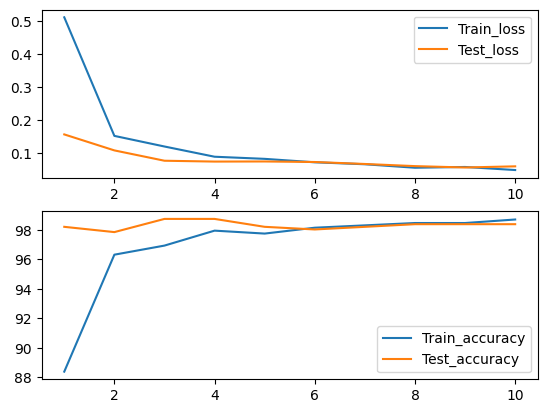

In [ ]:
plt.subplot(2,1,1)
plt.plot(range(1,epoches+1),loss_train,label='Train_loss')
plt.plot(range(1,epoches+1),loss_test,label='Test_loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(range(1,epoches+1),accuracy_train,label='Train_accuracy')
plt.plot(range(1,epoches+1),accuracy_test,label='Test_accuracy')
plt.legend()
plt.show()

##Testing the model


###Downloading new images

In [ ]:
!mkdir new_images
!curl -o new_images/bike.jpg https://www.elite-wheels.com/wp-content/uploads/2023/08/Gravel-Bike.jpg
!curl -o new_images/motercycle.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Norton_Motorcycle.jpg/1200px-Norton_Motorcycle.jpg
!curl -o new_images/train.jpg https://img.etimg.com/thumb/width-1200,height-900,imgsize-1063601,resizemode-75,msid-115732108/industry/transportation/railways/high-speed-trains-indian-railways-280-kmph-speed-aerodynamic-design-indias-next-high-speed-trains-are-coming-soon-beml-icf-ashwini-vaishnaw.jpg
!curl -o new_images/plane.jpg https://upload.wikimedia.org/wikipedia/commons/4/4d/IndiGo_Airbus_A320neo_F-WWDG_%28to_VT-ITI%29_%2828915135713%29.jpg
!curl -o new_images/car.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg/960px-2019_Toyota_Corolla_Icon_Tech_VVT-i_Hybrid_1.8.jpg
!curl -o new_images/ship.jpg https://images.newscientist.com/wp-content/uploads/2024/08/28215705/SEI_218932970.jpg
!curl -o new_images/auto.jpg https://content.jdmagicbox.com/comp/coimbatore/t8/0422px422.x422.190321111052.b2t8/catalogue/lsk-passenger-auto-nggo-colony-coimbatore-auto-rickshaw-services-fqgrtd37k5.jpg


mkdir: new_images: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  166k  100  166k    0     0   502k      0 --:--:-- --:--:-- --:--:--  502k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  265k  100  265k    0     0   521k      0 --:--:-- --:--:-- --:--:--  520k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  977k  100  977k    0     0  2662k      0 --:--:-- --:--:-- --:--:--     0:-- 2663k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2371k  100 2371k    0     0  3319k      0 --:--:-- --:--:-- --:--:-- 3316k
  % Total   

### Testing with new images

###Testing with model1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


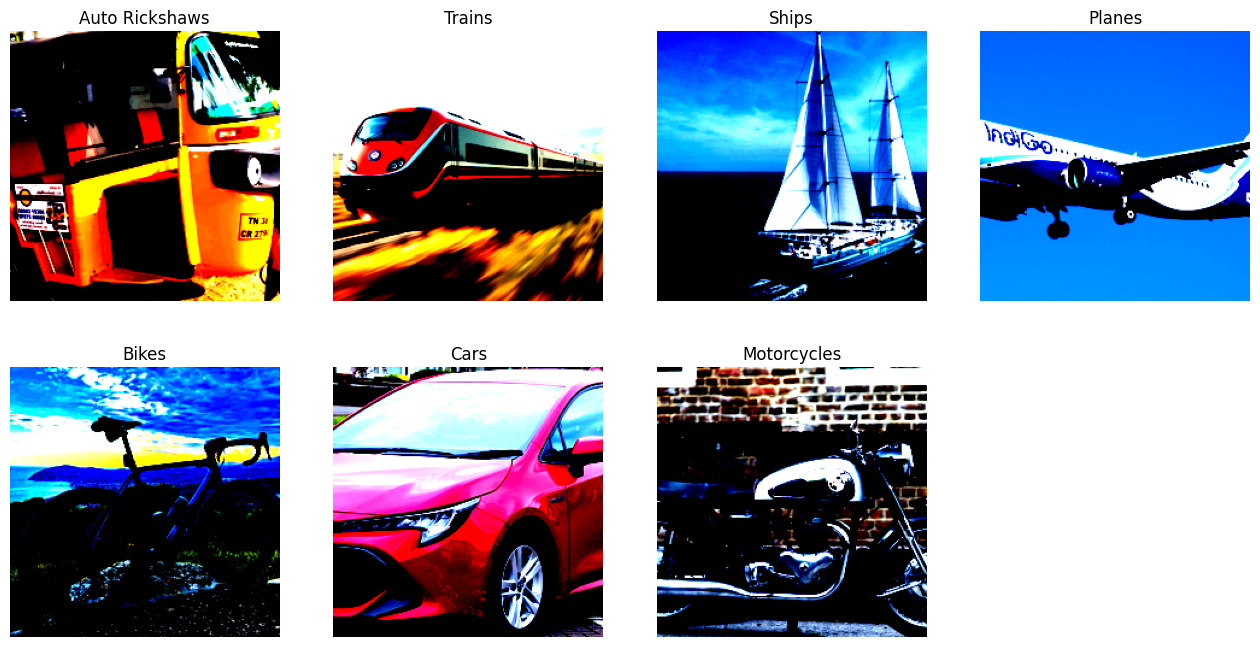

In [ ]:
i=0
plt.figure(figsize=(16,8))
for the_img in os.listdir('new_images'):
    img=cv.imread(f'new_images/{the_img}')
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    transform=transforms.Compose([
        transforms.Resize((256)),
        transforms.ToTensor(),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = Image.fromarray(img)
    img=transform(img)
    img=img.unsqueeze(0)
    model1.eval()
    with torch.no_grad():
        output = model1(img.to(device))
        value, predicted_class = output.max(1)
    plt.subplot(2,4,i+1)
    img=img.squeeze(0)
    plt.imshow(img.permute(1,2,0))
    plt.title(class_names[predicted_class])
    plt.axis('off')
    i+=1